## Imports

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons

## Getting the datasets


In [ ]:
!mkdir -p local_datasets
!wget --quiet "https://raw.githubusercontent.com/sauloafoliveira/cclw-mlm/master/local_datasets/datasets-7627-10826-banana.csv" -O "local_datasets/datasets-7627-10826-banana.csv"
!wget --quiet "https://raw.githubusercontent.com/sauloafoliveira/cclw-mlm/master/local_datasets/rip.csv" -O "local_datasets/rip.csv"

Banana

<Axes: xlabel='At1', ylabel='At2'>

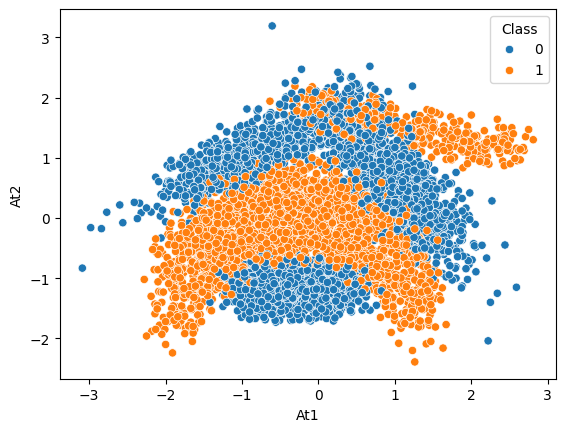

In [ ]:
df_banana = pd.read_csv('local_datasets/datasets-7627-10826-banana.csv')
df_banana['Class'] = (df_banana['Class'] > 0).astype(int)
sns.scatterplot(data=df_banana, x='At1', y='At2', hue='Class')

Ripley

<Axes: xlabel='At1', ylabel='At2'>

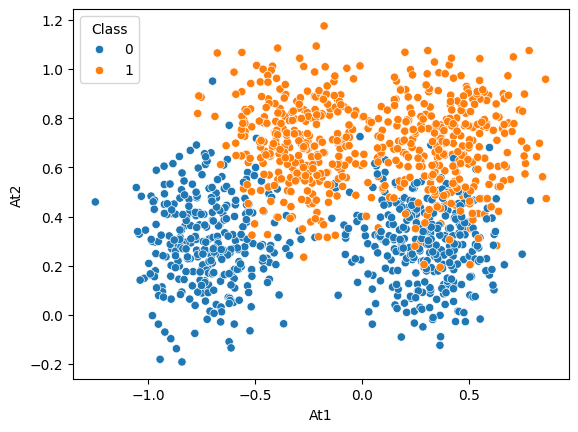

In [ ]:
df_ripley = pd.read_csv('local_datasets/rip.csv', header = None)
df_ripley.columns = ['At1', 'At2', 'Class']
df_ripley['Class'] = (df_ripley['Class'] > 1.5).astype(int)
sns.scatterplot(data=df_ripley, x='At1', y='At2', hue='Class')

Two Moons

<Axes: xlabel='At1', ylabel='At2'>

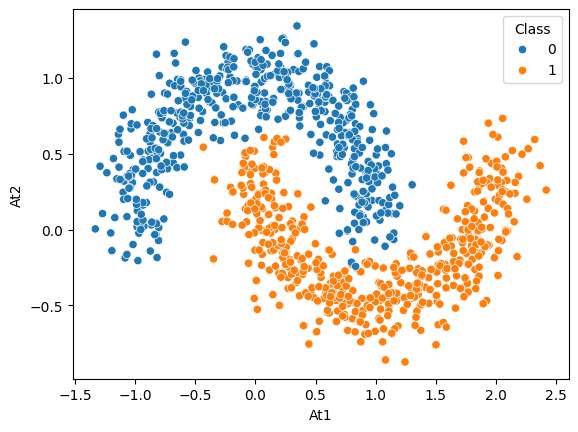

In [ ]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.15, random_state=42)
df_moons = pd.DataFrame(X_moons, columns=['At1', 'At2'])
df_moons['Class'] = y_moons
sns.scatterplot(data=df_moons, x='At1', y='At2', hue='Class')

## Multi-Layer Perceptron

In [ ]:
class MLP():
  def __init__(self, n_neurons = 3, n_layers = 2, learning_rate = 0.01):
    self.n_neurons = n_neurons
    self.n_layers = n_layers
    self.learning_rate = learning_rate


  def sigmoid(self, x):
    x = np.clip(x, -10000, 10000)
    return 1 / (1 + np.exp(-x))

  def sigmoid_derivative(self, x):
    return x * (1 - x)


  def initialize_parameters(self, n_neurons, n_layers, input_dim):

    self.weights = []
    self.biases = []

    layer_input_dim = input_dim

    for _ in range(n_layers):
       #  Xavier inicialization
        self.weights.append(np.random.randn(n_neurons, layer_input_dim) * np.sqrt(2. / layer_input_dim))
        self.biases.append(np.zeros((n_neurons, 1)))
        layer_input_dim = n_neurons


  def forward_propagation(self, X):

    A = X.T
    self.activations = [A]

    for l in range(self.n_layers):
      # Z = Weight * Activation + Bias
      Z = np.dot(self.weights[l], A) + self.biases[l]
      A = self.sigmoid(Z)
      self.activations.append(A)

    return A

  def backward_propagation(self, X, y):
    # I hate this shit, should have paid more attention to my calculus classes

    m = y.shape[0]
    A = np.clip(self.activations[-1], 1e-8, 1 - 1e-8)

    # initial error (dA) represents the gradient of the binary cross-entropy loss with respect to the output activation, A.
    # This took me a long while to understand, dear god.
    dA = -(np.divide(y, A) - np.divide(1 - y, 1 - A))

    dW = [None] * self.n_layers
    dB = [None] * self.n_layers

    for l in reversed(range(self.n_layers)):
        A = self.activations[l + 1]

        dZ = dA * self.sigmoid_derivative(A)

        dW[l] = (1 / m) * np.dot(dZ, self.activations[l].T)
        dB[l] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)

        dA = np.dot(self.weights[l].T, dZ)

        self.weights[l] -= self.learning_rate * dW[l]
        self.biases[l] -= self.learning_rate * dB[l]

    return dW, dB

  def fit(self, X_train, y_train, epochs = 1000):
    input_dim = X_train.shape[1]
    self.initialize_parameters(self.n_neurons, self.n_layers, input_dim)

    for epoch in range(epochs):
      output = self.forward_propagation(X_train)
      dW, dB = self.backward_propagation(X_train, y_train)

      #self.update_parameters(dW, dB)

  def predict(self, X_test):
    output = self.forward_propagation(X_test)
    predictions = (output > 0.5).astype(int)
    return predictions[0]

## Metrics

In [ ]:
def metrics(y_test, y_pred):
    TP = np.sum((y_test == 1) & (y_pred == 1))  # True Positives
    FP = np.sum((y_test == 0) & (y_pred == 1))  # False Positives
    FN = np.sum((y_test == 1) & (y_pred == 0))  # False Negatives
    TN = np.sum((y_test == 0) & (y_pred == 0))  # True Negatives

    accuracy = (TP + TN) / len(y_test)

    # Calculate Precision
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    # Calculate Recall
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calculate F1-Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1_score

## Main

In [ ]:
results = pd.DataFrame(columns = ['dataset','n_neurons', 'n_layers', 'learning_rate', 'accuracy', 'recall', 'precision', 'F1-Score'])

for dataset in ['df_moons', 'df_banana', 'df_ripley']:

  dataset_group = {
                    'df_moons' : df_moons,
                    'df_banana' : df_banana,
                    'df_ripley' : df_ripley
                  }

  X = dataset_group[dataset][['At1', 'At2']]
  y = dataset_group[dataset]['Class']
  for n_neurons in range(4, 10):
    for n_layers in range(1, 5):
      for learning_rate in [0.01, 0.1, 0.5]:
        for _ in range(10):
          X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2)

          mlp = MLP(n_neurons = n_neurons, n_layers = n_layers, learning_rate = learning_rate)
          mlp.fit(X_train, y_train)

          y_pred = mlp.predict(X_test)

          accuracy, precision, recall, f1_score = metrics(y_test, y_pred)

          results.loc[len(results)] = [dataset, n_neurons, n_layers, learning_rate, accuracy, recall, precision, f1_score]

results = results.groupby(['dataset', 'n_neurons', 'n_layers', 'learning_rate'], as_index=False).agg(['mean', 'std'])

In [ ]:
results

dataset n_neurons n_layers learning_rate  accuracy              recall  \
                                                     mean       std      mean   
0    df_banana         4        1          0.01  0.514340  0.057448  0.188032   
1    df_banana         4        1          0.10  0.552453  0.018235  0.120385   
2    df_banana         4        1          0.50  0.547075  0.016379  0.126760   
3    df_banana         4        2          0.01  0.531038  0.048772  0.131122   
4    df_banana         4        2          0.10  0.561887  0.088187  0.278804   
..         ...       ...      ...           ...       ...       ...       ...   
211  df_ripley         9        3          0.10  0.874000  0.015578  0.863827   
212  df_ripley         9        3          0.50  0.906800  0.014367  0.897139   
213  df_ripley         9        4          0.01  0.526800  0.066934  0.362307   
214  df_ripley         9        4          0.10  0.879600  0.014416  0.873084   
215  df_ripley         9        4          0.50  0.905600  0.019432  0.918553   

              precision            F1-Score            
          std      mean       std      mean       std  
0    0.124521  0.469491  0.212987  0.240226  0.123495  
1    0.035630  0.588019  0.175241  0.191994  0.041805  
2    0.022996  0.506572  0.072287  0.200698  0.028769  
3    0.166519  0.266221  0.249929  0.157830  0.180837  
4    0.127101  0.563155  0.189281  0.357390  0.145453  
..        ...       ...       ...       ...       ...  
211  0.019019  0.882518  0.030996  0.872713  0.017797  
212  0.029492  0.917373  0.030430  0.906587  0.017957  
213  0.363660  0.379027  0.354983  0.338557  0.299193  
214  0.021614  0.882130  0.020754  0.877409  0.016724  
215  0.029512  0.888177  0.042123  0.902207  0.021884  

[216 rows x 12 columns]

## Plotting the results with best F1-Score

In [ ]:
results.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in results.columns]

In [ ]:
best_result = results.loc[results.groupby('dataset')['F1-Score_mean'].idxmax()]
best_result

,dataset,n_neurons,n_layers,learning_rate,accuracy_mean,accuracy_std,recall_mean,recall_std,precision_mean,precision_std,F1-Score_mean,F1-Score_std
68,df_banana,9,3,0.5,0.881321,0.007426,0.842196,0.048369,0.894569,0.036428,0.865807,0.013493
119,df_moons,7,4,0.5,0.989500,0.007246,0.991455,0.014043,0.986921,0.006544,0.989133,0.008226
191,df_ripley,7,4,0.5,0.911600,0.014292,0.916626,0.041074,0.908443,0.042695,0.910894,0.011426
